# Policy Gradient 

This Notebook reimplements Karpathy's basic policy gradient agent in PyTorch without GPU acceleration.

It is meant to be run on the laptop for code development. After code is stable, it will be translated to the AI Workstation with GPU acceleration for long training sessions.

In [1]:
# As usual, a bit of setup
from __future__ import print_function
import time
import numpy as np
import matplotlib.pyplot as plt
import platform
import gym
import torch

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

print("Python version: ", platform.python_version())

Python version:  3.6.3


In [ ]:
env.close()

## Karpathy Basic Policy Gradient "Pong"

The following code uses a basic policy gradient method to train a 2 layer NN to play Pong.

The time needed to train 10 episodes is 13 sec with CPU.

The forward pass takes 4 seconds. So implementing this in PyTorch and using GPU will speed things up by 30%.

In [3]:
""" Trains an agent with (stochastic) Policy Gradients on Pong. Uses OpenAI Gym. """
import numpy as np
import pickle as pickle
import gym

# hyperparameters
H = 200 # number of hidden layer neurons
batch_size = 10 # every how many episodes to do a param update?

learning_rate  = 1e-3
epoch_reward_history=[]
    
gamma = 0.99 # discount factor for reward
decay_rate = 0.99 # decay factor for RMSProp leaky sum of grad^2
resume = False # resume from previous checkpoint?
render = False

# model initialization
D = 80 * 80 # input dimensionality: 80x80 grid
if resume:
  model = pickle.load(open('save.p', 'rb'))
else:
  model = {}
  model['W1'] = np.random.randn(H,D) / np.sqrt(D) # "Xavier" initialization
  model['W2'] = np.random.randn(H) / np.sqrt(H)

grad_buffer = { k : np.zeros_like(v) for k,v in model.items() } # update buffers that add up gradients over a batch
rmsprop_cache = { k : np.zeros_like(v) for k,v in model.items() } # rmsprop memory

def sigmoid(x): 
  return 1.0 / (1.0 + np.exp(-x)) # sigmoid "squashing" function to interval [0,1]

def prepro(I):
  """ prepro 210x160x3 uint8 frame into 6400 (80x80) 1D float vector """
  I = I[35:195] # crop
  I = I[::2,::2,0] # downsample by factor of 2
  I[I == 144] = 0 # erase background (background type 1)
  I[I == 109] = 0 # erase background (background type 2)
  I[I != 0] = 1 # everything else (paddles, ball) just set to 1
  return I.astype(np.float).ravel()

def discount_rewards(r):
  """ take 1D float array of rewards and compute discounted reward """
  discounted_r = np.zeros_like(r)
  running_add = 0
  for t in reversed(range(0, r.size)):
    if r[t] != 0: running_add = 0 # reset the sum, since this was a game boundary (pong specific!)
    running_add = running_add * gamma + r[t]
    discounted_r[t] = running_add
  return discounted_r

def policy_forward(x):
  h = np.dot(model['W1'], x)
  h[h<0] = 0 # ReLU nonlinearity
  logp = np.dot(model['W2'], h)
  p = sigmoid(logp)
  return p, h # return probability of taking action 2, and hidden state

def policy_backward(eph, epdlogp):
  """ backward pass. (eph is array of intermediate hidden states) """
  dW2 = np.dot(eph.T, epdlogp).ravel()
  dh = np.outer(epdlogp, model['W2'])
  dh[eph <= 0] = 0 # backpro prelu
  dW1 = np.dot(dh.T, epx)
  return {'W1':dW1, 'W2':dW2}

env = gym.make("Pong-v0")
observation = env.reset()
prev_x = None # used in computing the difference frame
xs,hs,dlogps,drs = [],[],[],[]
running_reward = None
verbose = False
print_every = 20
reward_sum = 0
episode_number = 0
forward_time=0
backward_time=0
other_time=0

start = time.time()

while episode_number < 1000:
  if render: env.render()

  # preprocess the observation, set input to network to be difference image
  cur_x = prepro(observation)
  x = cur_x - prev_x if prev_x is not None else np.zeros(D)
  prev_x = cur_x

  # forward the policy network and sample an action from the returned probability
  t1 = time.time()
  aprob, h = policy_forward(x)
  action = 2 if np.random.uniform() < aprob else 3 # roll the dice!
  t2 = time.time()
  forward_time += t2-t1

  # record various intermediates (needed later for backprop)
  xs.append(x) # observation
  hs.append(h) # hidden state
  y = 1 if action == 2 else 0 # a "fake label"
  dlogps.append(y - aprob) # grad that encourages the action that was taken to be taken 
  # (see http://cs231n.github.io/neural-networks-2/#losses if confused)

  # step the environment and get new measurements
  t5 = time.time()  
  # step the environment and get new measurements
  observation, reward, done, info = env.step(action)
  reward_sum += reward

  t6 = time.time()
  other_time += t6-t5

  drs.append(reward) # record reward (has to be done after we call step() to get reward for previous action)

  if done: # an episode finished
    episode_number += 1

    # stack together all inputs, hidden states, action gradients, and rewards for this episode
    epx = np.vstack(xs)
    eph = np.vstack(hs)
    epdlogp = np.vstack(dlogps)
    epr = np.vstack(drs)
    xs,hs,dlogps,drs = [],[],[],[] # reset array memory

    # compute the discounted reward backwards through time
    discounted_epr = discount_rewards(epr)
    # standardize the rewards to be unit normal (helps control the gradient estimator variance)
    discounted_epr -= np.mean(discounted_epr)
    discounted_epr /= np.std(discounted_epr)

    epdlogp *= discounted_epr # modulate the gradient with advantage (PG magic happens right here.)
    
    t3 = time.time()    
    grad = policy_backward(eph, epdlogp)
    t4 = time.time()
    backward_time += t4-t3    
    
    for k in model: 
        grad_buffer[k] += grad[k] # accumulate grad over batch

    # perform rmsprop parameter update every batch_size episodes
    if episode_number % batch_size == 0:
      for k,v in model.items():
        g = grad_buffer[k] # gradient
        rmsprop_cache[k] = decay_rate * rmsprop_cache[k] + (1 - decay_rate) * g**2
        model[k] += learning_rate * g / (np.sqrt(rmsprop_cache[k]) + 1e-5)
        grad_buffer[k] = np.zeros_like(v) # reset batch gradient buffer

    # boring book-keeping
    running_reward = reward_sum if running_reward is None else running_reward * 0.99 + reward_sum * 0.01
    if episode_number % print_every == 0:     
        print ('Episode %d - reward total was %f. running mean: %f' % (episode_number, reward_sum, running_reward))

    epoch_reward_history.append([reward_sum, running_reward])
    if episode_number % 100 == 0: pickle.dump(model, open('save-cpu-lr1e-3-1000ep.p', 'wb'))
    reward_sum = 0
    observation = env.reset() # reset env
    prev_x = None

  if reward != 0 and verbose: # Pong has either +1 or -1 reward exactly when game ends.
    print (('ep %d: game finished, reward: %f' % (episode_number, reward)) + ('' if reward == -1 else ' !!!!!!!!'))
    
end = time.time()
print ("Time to complete", end-start)
print ("Time to forward pass", forward_time)
print ("Time to backward pass", backward_time)
print ("Time to other stuffs", other_time)

Episode 20 - reward total was -21.000000. running mean: -20.964255
Episode 40 - reward total was -21.000000. running mean: -20.840709
Episode 60 - reward total was -20.000000. running mean: -20.752657
Episode 80 - reward total was -20.000000. running mean: -20.652472
Episode 100 - reward total was -21.000000. running mean: -20.499510
Episode 120 - reward total was -19.000000. running mean: -20.352835
Episode 140 - reward total was -21.000000. running mean: -20.343211
Episode 160 - reward total was -20.000000. running mean: -20.267170
Episode 180 - reward total was -21.000000. running mean: -20.196141
Episode 200 - reward total was -18.000000. running mean: -20.157837
Episode 220 - reward total was -19.000000. running mean: -20.119638
Episode 240 - reward total was -21.000000. running mean: -20.131668
Episode 260 - reward total was -21.000000. running mean: -20.177770
Episode 280 - reward total was -20.000000. running mean: -20.144430
Episode 300 - reward total was -19.000000. running m

### Observations (Laptop CPU)

Time to train 1000 episodes is 2400 seconds or 40 minutes. Over 1100 seconds are consumed by OpenAI Gym stepping through its environment (1 second per step).  

The agent achieved under -19.0 running reward and highs of -13 reward sum after 1000 episodes.

The trained model is in save-cpu-lr1e-3-1000ep.p



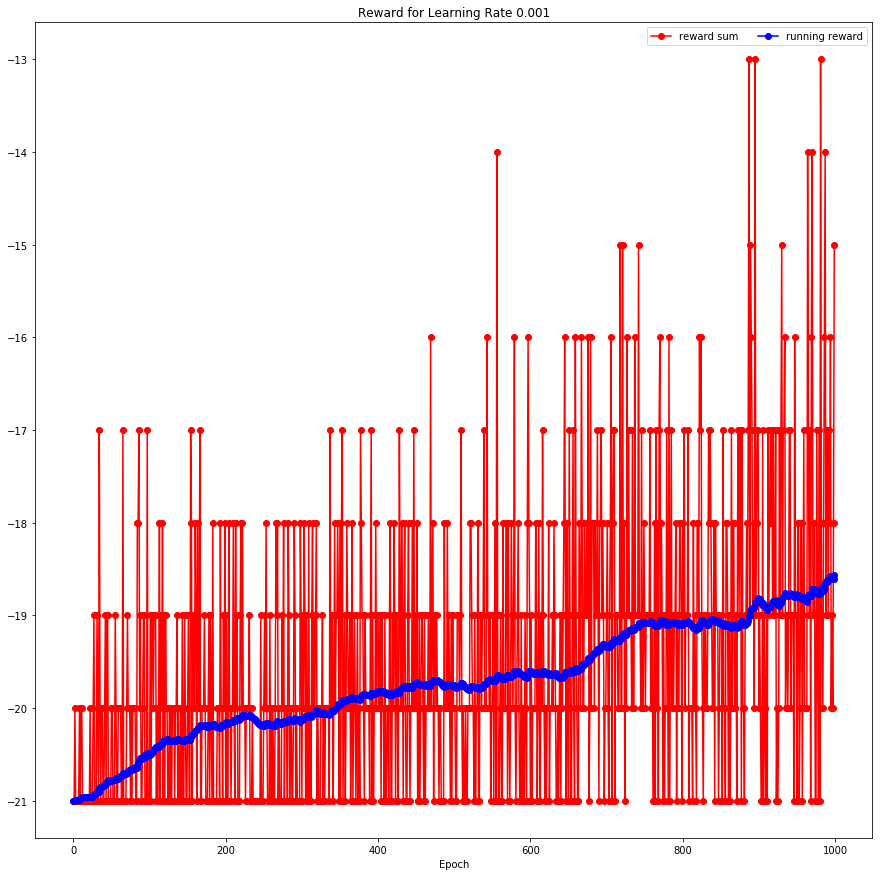

In [4]:
history = np.array(epoch_reward_history)

# Plot out the accuracies
plt.title('Reward for Learning Rate '+str(learning_rate))
plt.xlabel('Epoch')
plt.plot(history[:,0], '-ro', label="reward sum")
plt.plot(history[:,1], '-bo', label="running reward")
plt.legend(loc='best', ncol=4)

 
plt.gcf().set_size_inches(15, 15)
plt.show()

### Variability of Training

How well a model train is variable. For the training session below, the agent achieved close to -16 running reward and highs of -6 reward sum after the same 1000 episodes, which is much better than the training session before it.

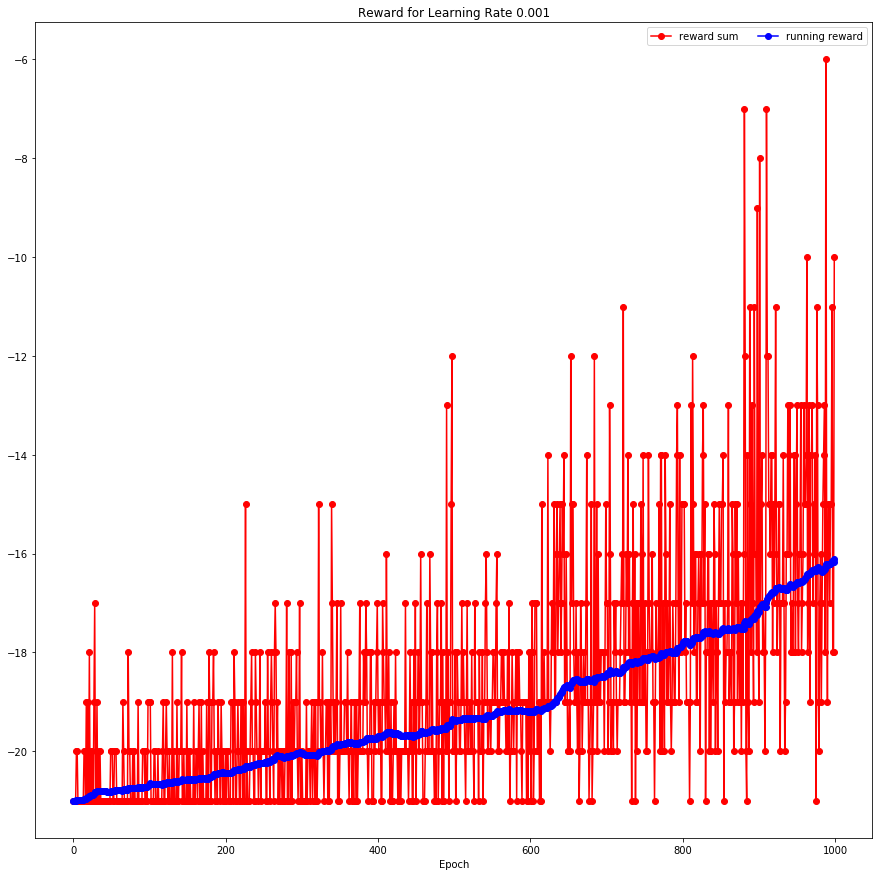

In [262]:
history = np.array(epoch_reward_history)

# Plot out the accuracies
plt.title('Reward for Learning Rate '+str(learning_rate))
plt.xlabel('Epoch')
plt.plot(history[:,0], '-ro', label="reward sum")
plt.plot(history[:,1], '-bo', label="running reward")
plt.legend(loc='best', ncol=4)

 
plt.gcf().set_size_inches(15, 15)
plt.show()

pickle.dump(model, open('reward_lr_1e-3_1000ep_numpy.p', 'wb'))

## PyTorch - Policy Gradient on Cartpole

The following code is PyTorch's official example for reinforcement learning. It trains a RL agent to master the simple game of Cartpole: 

https://github.com/pytorch/examples/blob/master/reinforcement_learning/reinforce.py

We need to better understand it so that we can port the Karpathy numpy code over.

In [33]:
import argparse
import gym
import numpy as np
from itertools import count

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.distributions import Categorical

gamma=0.99
seed=543
render=False
log_interval=50
verbose=True  # To step through the code and understand what is going on

env = gym.make('CartPole-v0')
env.seed(seed)
torch.manual_seed(seed)

# A 2-layer NN with 128 hidden units
class Policy(nn.Module):
    def __init__(self):
        super(Policy, self).__init__()
        self.affine1 = nn.Linear(4, 128)
        self.affine2 = nn.Linear(128, 2)

        self.saved_log_probs = []
        self.rewards = []

    def forward(self, x):
        x = F.relu(self.affine1(x))
        action_scores = self.affine2(x)
        return F.softmax(action_scores, dim=1)


policy = Policy()
optimizer = optim.Adam(policy.parameters(), lr=1e-2)

def select_action(state):
    """ Use policy to determine an action based on state provided """
    
    state = torch.from_numpy(state).float().unsqueeze(0)
    if verbose:
        print ("This is CartPole's state output:", state)
    probs = policy(Variable(state))
    if verbose:
        print ("This is softmax output from NN:", probs)

    m = Categorical(probs)
    action = m.sample()
    if verbose:
        print ("Action sampled:", action, action.data[0])
        print ("log_prob(action) saved by policy:", m.log_prob(action))
    
    policy.saved_log_probs.append(m.log_prob(action))
    return action.data[0]


def finish_episode():
    R = 0
    policy_loss = []
    rewards = []
    
    if verbose:
        print ("Rewards stored by policy:", policy.rewards)
    
    # Generate a list of gamma-discounted rewards based on rewards[] list stored by policy 
    for r in policy.rewards[::-1]:
        R = r + gamma * R
        rewards.insert(0, R)
    rewards = torch.Tensor(rewards)
    if verbose:
        print ("Gamma-discounted rewards:", rewards)

    rewards = (rewards - rewards.mean()) / (rewards.std() + np.finfo(np.float32).eps)
    if verbose:
        print ("Normalized gamma-discounted rewards:", rewards)   

    # Generate policy_loss list
    for log_prob, reward in zip(policy.saved_log_probs, rewards):
        policy_loss.append(-log_prob * reward)

    if verbose:
        print ("Policy loss:", policy_loss)  
        
    optimizer.zero_grad()  # zero the gradients before running the optimizer
    
    policy_loss = torch.cat(policy_loss).sum()
    
    if verbose:
        print ("Policy loss (after cat and sum):", policy_loss)  
    
    policy_loss.backward()  # The TRICK: backward() on policy_loss instead of policy
    
    optimizer.step()
    
    del policy.rewards[:]
    del policy.saved_log_probs[:]


# Main loop
running_reward = 10
# for i_episode in count(1):
for i_episode in range(1): # just run 1 episode    
    state = env.reset()
    
    for t in range(10000):  # Don't infinite loop while learning
        
        # select an action based on the state provided by env
        action = select_action(state)
        
        # step the environment through the action
        state, reward, done, _ = env.step(action)
        
        if render:
            env.render()
            
        # append reward to policy's reward[] list   
        policy.rewards.append(reward)
        
        # break if episode is done
        if done:
            break

    running_reward = running_reward * 0.99 + t * 0.01   # calculate running reward
    
    # this is where the heavy lifting (back prop) is done 
    finish_episode()
    
    # print out and show sign of life
    if i_episode % log_interval == 0:
        print('Episode {}\tLast length: {:5d}\tAverage length: {:.2f}'.format(
                i_episode, t, running_reward))
    if running_reward > env.spec.reward_threshold:
        print("Solved! Running reward is now {} and "
                  "the last episode runs to {} time steps!".format(running_reward, t))
        break


WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
This is CartPole's state output: 
1.00000e-02 *
  0.2602  2.6891 -1.3696 -2.0036
[torch.FloatTensor of size 1x4]

This is softmax output from NN: Variable containing:
 0.5007  0.4993
[torch.FloatTensor of size 1x2]

Action sampled: Variable containing:
 0
[torch.LongTensor of size 1]
 0
log_prob(action) saved by policy: Variable containing:
-0.6917
[torch.FloatTensor of size 1]

This is CartPole's state output: 
 0.0031 -0.1680 -0.0141  0.2683
[torch.FloatTensor of size 1x4]

This is softmax output from NN: Variable containing:
 0.5096  0.4904
[torch.FloatTensor of size 1x2]

Action sampled: Variable containing:
 0
[torch.LongTensor of size 1]
 0
log_prob(action) saved by policy: Variable containing:
-0.6741
[torch.FloatTensor of size 1]

This is CartPole's state output: 
-0.0002 -0.3629 -0.0087  0.5565
[torch.FloatTensor of size 1x4]

This is softmax output from NN: Variable containing:


In [30]:
import argparse
import gym
import numpy as np
from itertools import count

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.distributions import Categorical

gamma=0.99
seed=543
render=False
log_interval=50
verbose=False  # To step through the code and understand what is going on

env = gym.make('CartPole-v0')
env.seed(seed)
torch.manual_seed(seed)

# A 2-layer NN with 128 hidden units
class Policy(nn.Module):
    def __init__(self):
        super(Policy, self).__init__()
        self.affine1 = nn.Linear(4, 128)
        self.affine2 = nn.Linear(128, 2)

        self.saved_log_probs = []
        self.rewards = []

    def forward(self, x):
        x = F.relu(self.affine1(x))
        action_scores = self.affine2(x)
        return F.softmax(action_scores, dim=1)

policy = Policy()
optimizer = optim.Adam(policy.parameters(), lr=1e-2)

def select_action(state):
    state = torch.from_numpy(state).float().unsqueeze(0)
    probs = policy(Variable(state))
    m = Categorical(probs)
    action = m.sample()
    policy.saved_log_probs.append(m.log_prob(action))
    return action.data[0]


def finish_episode():
    R = 0
    policy_loss = []
    rewards = []
    for r in policy.rewards[::-1]:
        R = r + gamma * R
        rewards.insert(0, R)
    rewards = torch.Tensor(rewards)
    rewards = (rewards - rewards.mean()) / (rewards.std() + np.finfo(np.float32).eps)
    for log_prob, reward in zip(policy.saved_log_probs, rewards):
        policy_loss.append(-log_prob * reward)
    optimizer.zero_grad()
    policy_loss = torch.cat(policy_loss).sum()
    policy_loss.backward()
    optimizer.step()
    del policy.rewards[:]
    del policy.saved_log_probs[:]


# Main loop
running_reward = 10
for i_episode in count(1):
    state = env.reset()
    for t in range(10000):  # Don't infinite loop while learning
        action = select_action(state)
        state, reward, done, _ = env.step(action)
        if render:
            env.render()
        policy.rewards.append(reward)
        if done:
            break

    running_reward = running_reward * 0.99 + t * 0.01
    finish_episode()
    
    if i_episode % log_interval == 0:
        print('Episode {}\tLast length: {:5d}\tAverage length: {:.2f}'.format(
                i_episode, t, running_reward))
    if running_reward > env.spec.reward_threshold:
        print("Solved! Running reward is now {} and "
                  "the last episode runs to {} time steps!".format(running_reward, t))
        break


WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Episode 50	Last length:    28	Average length: 10.84
Episode 100	Last length:    42	Average length: 20.58
Episode 150	Last length:    72	Average length: 30.69
Episode 200	Last length:    40	Average length: 41.11
Episode 250	Last length:    74	Average length: 39.69
Episode 300	Last length:   132	Average length: 52.62
Episode 350	Last length:   108	Average length: 69.47
Episode 400	Last length:    85	Average length: 79.72
Episode 450	Last length:   171	Average length: 108.03
Episode 500	Last length:   199	Average length: 143.93
Episode 550	Last length:   199	Average length: 165.50
Episode 600	Last length:   199	Average length: 178.73
Episode 650	Last length:   199	Average length: 186.74
Episode 700	Last length:   124	Average length: 187.69
Episode 750	Last length:   199	Average length: 184.40
Episode 800	Last length:   199	Average length: 153.96
Episode 850	Last length:   107	Average length:

## PyTorch - Policy Gradient on Pong

Here we go now!!!


In [42]:
import argparse
import gym
import numpy as np
from itertools import count

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.distributions import Categorical

gamma=0.99
seed=543
render=False
log_interval=50
verbose=True  # To step through the code and understand what is going on

env = gym.make("Pong-v0")
env.seed(seed)
torch.manual_seed(seed)

# A 2-layer NN with 200 hidden units and output of 2 actions (different from Karpathy)
class Policy(nn.Module):
    def __init__(self):
        super(Policy, self).__init__()
        self.affine1 = nn.Linear(6400, 200)
        self.affine2 = nn.Linear(200, 2)  
        
        # Not sure what these are
        self.saved_log_probs = []
        self.rewards = []

    def forward(self, x):
        x = F.relu(self.affine1(x))
        action_scores = self.affine2(x)
        return F.softmax(action_scores, dim=1)

policy = Policy()
optimizer = optim.Adam(policy.parameters(), lr=1e-3)


def prepro(I):
    """ prepro 210x160x3 uint8 frame into 6400 (80x80) 1D float vector """
    I = I[35:195] # crop
    I = I[::2,::2,0] # downsample by factor of 2
    I[I == 144] = 0 # erase background (background type 1)
    I[I == 109] = 0 # erase background (background type 2)
    I[I != 0] = 1 # everything else (paddles, ball) just set to 1
    return I.astype(np.float).ravel()


def select_action(state):
    """ 
    Use policy to determine an action based on state provided. While the NN will generate softmax output
    for action 0 and 1. 
    
    The output expected by the PONG environment is:
    ['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']
    
    So we need to return 2 (UP/RIGHT) and 3(DOWN/LEFT)
    """
    
    
    state = torch.from_numpy(state).float().unsqueeze(0)
    if verbose:
        print ("This is Pong's state output:", state.shape, state)
    probs = policy(Variable(state))
    if verbose:
        print ("This is softmax output from NN:", probs)

    m = Categorical(probs)
    action = m.sample()
    if verbose:
        print ("Action generated by NN:", action)
        print ("Action to PONG:", action.data[0]+2)
        print ("log_prob(action) saved by policy:", m.log_prob(action))
    
    policy.saved_log_probs.append(m.log_prob(action))
    return action.data[0]+2  # UP=2, DOWN=3 

prev_x = None

# Main loop
running_reward = -21
# for i_episode in count(1):
for i_episode in range(1): # just run 1 episode    
    state = env.reset()
    
    for t in range(10000):  # Don't infinite loop while learning
        
        cur_x = prepro(state)
        state = cur_x - prev_x if prev_x is not None else np.zeros(6400)
        prev_x = cur_x
        
        # select an action based on the state provided by env
        action = select_action(state)
       
        # step the environment through the action
        state, reward, done, _ = env.step(action)
        
        if render:
            env.render()
            
        # append reward to policy's reward[] list   
        policy.rewards.append(reward)
        
        # break if episode is done
        if done:
            break

    running_reward = running_reward * 0.99 + t * 0.01   # calculate running reward
    
    # this is where the heavy lifting (back prop) is done 
    # finish_episode()
    
    # print out and show sign of life
    if i_episode % log_interval == 0:
        print('Episode {}\tLast length: {:5d}\tAverage length: {:.2f}'.format(
                i_episode, t, running_reward))
    if i_episode > 10000:
        print("Taking too long, Exit.")
        break


This is Pong's state output: torch.Size([1, 6400]) 
    0     0     0  ...      0     0     0
[torch.FloatTensor of size 1x6400]

This is softmax output from NN: Variable containing:
 0.5161  0.4839
[torch.FloatTensor of size 1x2]

Action generated by NN: Variable containing:
 1
[torch.LongTensor of size 1]

Action to PONG: 3
log_prob(action) saved by policy: Variable containing:
-0.7259
[torch.FloatTensor of size 1]

This is Pong's state output: torch.Size([1, 6400]) 
    0     0     0  ...      0     0     0
[torch.FloatTensor of size 1x6400]

This is softmax output from NN: Variable containing:
 0.5144  0.4856
[torch.FloatTensor of size 1x2]

Action generated by NN: Variable containing:
 0
[torch.LongTensor of size 1]

Action to PONG: 2
log_prob(action) saved by policy: Variable containing:
-0.6647
[torch.FloatTensor of size 1]

This is Pong's state output: torch.Size([1, 6400]) 
    0     0     0  ...      0     0     0
[torch.FloatTensor of size 1x6400]

This is softmax output fro

This is Pong's state output: torch.Size([1, 6400]) 
    0     0     0  ...      0     0     0
[torch.FloatTensor of size 1x6400]

This is softmax output from NN: Variable containing:
 0.5135  0.4865
[torch.FloatTensor of size 1x2]

Action generated by NN: Variable containing:
 1
[torch.LongTensor of size 1]

Action to PONG: 3
log_prob(action) saved by policy: Variable containing:
-0.7205
[torch.FloatTensor of size 1]

This is Pong's state output: torch.Size([1, 6400]) 
    0     0     0  ...      0     0     0
[torch.FloatTensor of size 1x6400]

This is softmax output from NN: Variable containing:
 0.5153  0.4847
[torch.FloatTensor of size 1x2]

Action generated by NN: Variable containing:
 0
[torch.LongTensor of size 1]

Action to PONG: 2
log_prob(action) saved by policy: Variable containing:
-0.6631
[torch.FloatTensor of size 1]

This is Pong's state output: torch.Size([1, 6400]) 
    0     0     0  ...      0     0     0
[torch.FloatTensor of size 1x6400]

This is softmax output fro

This is Pong's state output: torch.Size([1, 6400]) 
    0     0     0  ...      0     0     0
[torch.FloatTensor of size 1x6400]

This is softmax output from NN: Variable containing:
 0.5122  0.4878
[torch.FloatTensor of size 1x2]

Action generated by NN: Variable containing:
 0
[torch.LongTensor of size 1]

Action to PONG: 2
log_prob(action) saved by policy: Variable containing:
-0.6690
[torch.FloatTensor of size 1]

This is Pong's state output: torch.Size([1, 6400]) 
    0     0     0  ...      0     0     0
[torch.FloatTensor of size 1x6400]

This is softmax output from NN: Variable containing:
 0.5146  0.4854
[torch.FloatTensor of size 1x2]

Action generated by NN: Variable containing:
 1
[torch.LongTensor of size 1]

Action to PONG: 3
log_prob(action) saved by policy: Variable containing:
-0.7228
[torch.FloatTensor of size 1]

This is Pong's state output: torch.Size([1, 6400]) 
    0     0     0  ...      0     0     0
[torch.FloatTensor of size 1x6400]

This is softmax output fro

This is Pong's state output: torch.Size([1, 6400]) 
    0     0     0  ...      0     0     0
[torch.FloatTensor of size 1x6400]

This is softmax output from NN: Variable containing:
 0.5202  0.4798
[torch.FloatTensor of size 1x2]

Action generated by NN: Variable containing:
 0
[torch.LongTensor of size 1]

Action to PONG: 2
log_prob(action) saved by policy: Variable containing:
-0.6536
[torch.FloatTensor of size 1]

This is Pong's state output: torch.Size([1, 6400]) 
    0     0     0  ...      0     0     0
[torch.FloatTensor of size 1x6400]

This is softmax output from NN: Variable containing:
 0.5102  0.4898
[torch.FloatTensor of size 1x2]

Action generated by NN: Variable containing:
 1
[torch.LongTensor of size 1]

Action to PONG: 3
log_prob(action) saved by policy: Variable containing:
-0.7137
[torch.FloatTensor of size 1]

This is Pong's state output: torch.Size([1, 6400]) 
    0     0     0  ...      0     0     0
[torch.FloatTensor of size 1x6400]

This is softmax output fro

This is Pong's state output: torch.Size([1, 6400]) 
    0     0     0  ...      0     0     0
[torch.FloatTensor of size 1x6400]

This is softmax output from NN: Variable containing:
 0.5184  0.4816
[torch.FloatTensor of size 1x2]

Action generated by NN: Variable containing:
 1
[torch.LongTensor of size 1]

Action to PONG: 3
log_prob(action) saved by policy: Variable containing:
-0.7306
[torch.FloatTensor of size 1]

This is Pong's state output: torch.Size([1, 6400]) 
    0     0     0  ...      0     0     0
[torch.FloatTensor of size 1x6400]

This is softmax output from NN: Variable containing:
 0.5137  0.4863
[torch.FloatTensor of size 1x2]

Action generated by NN: Variable containing:
 1
[torch.LongTensor of size 1]

Action to PONG: 3
log_prob(action) saved by policy: Variable containing:
-0.7209
[torch.FloatTensor of size 1]

This is Pong's state output: torch.Size([1, 6400]) 
    0     0     0  ...      0     0     0
[torch.FloatTensor of size 1x6400]

This is softmax output fro

This is Pong's state output: torch.Size([1, 6400]) 
    0     0     0  ...      0     0     0
[torch.FloatTensor of size 1x6400]

This is softmax output from NN: Variable containing:
 0.5211  0.4789
[torch.FloatTensor of size 1x2]

Action generated by NN: Variable containing:
 0
[torch.LongTensor of size 1]

Action to PONG: 2
log_prob(action) saved by policy: Variable containing:
-0.6519
[torch.FloatTensor of size 1]

This is Pong's state output: torch.Size([1, 6400]) 
    0     0     0  ...      0     0     0
[torch.FloatTensor of size 1x6400]

This is softmax output from NN: Variable containing:
 0.5111  0.4889
[torch.FloatTensor of size 1x2]

Action generated by NN: Variable containing:
 0
[torch.LongTensor of size 1]

Action to PONG: 2
log_prob(action) saved by policy: Variable containing:
-0.6712
[torch.FloatTensor of size 1]

This is Pong's state output: torch.Size([1, 6400]) 
    0     0     0  ...      0     0     0
[torch.FloatTensor of size 1x6400]

This is softmax output fro

This is Pong's state output: torch.Size([1, 6400]) 
    0     0     0  ...      0     0     0
[torch.FloatTensor of size 1x6400]

This is softmax output from NN: Variable containing:
 0.5124  0.4876
[torch.FloatTensor of size 1x2]

Action generated by NN: Variable containing:
 0
[torch.LongTensor of size 1]

Action to PONG: 2
log_prob(action) saved by policy: Variable containing:
-0.6687
[torch.FloatTensor of size 1]

This is Pong's state output: torch.Size([1, 6400]) 
    0     0     0  ...      0     0     0
[torch.FloatTensor of size 1x6400]

This is softmax output from NN: Variable containing:
 0.5116  0.4884
[torch.FloatTensor of size 1x2]

Action generated by NN: Variable containing:
 1
[torch.LongTensor of size 1]

Action to PONG: 3
log_prob(action) saved by policy: Variable containing:
-0.7166
[torch.FloatTensor of size 1]

This is Pong's state output: torch.Size([1, 6400]) 
    0     0     0  ...      0     0     0
[torch.FloatTensor of size 1x6400]

This is softmax output fro

log_prob(action) saved by policy: Variable containing:
-0.7296
[torch.FloatTensor of size 1]

This is Pong's state output: torch.Size([1, 6400]) 
    0     0     0  ...      0     0     0
[torch.FloatTensor of size 1x6400]

This is softmax output from NN: Variable containing:
 0.5201  0.4799
[torch.FloatTensor of size 1x2]

Action generated by NN: Variable containing:
 1
[torch.LongTensor of size 1]

Action to PONG: 3
log_prob(action) saved by policy: Variable containing:
-0.7341
[torch.FloatTensor of size 1]

This is Pong's state output: torch.Size([1, 6400]) 
    0     0     0  ...      0     0     0
[torch.FloatTensor of size 1x6400]

This is softmax output from NN: Variable containing:
 0.5102  0.4898
[torch.FloatTensor of size 1x2]

Action generated by NN: Variable containing:
 1
[torch.LongTensor of size 1]

Action to PONG: 3
log_prob(action) saved by policy: Variable containing:
-0.7137
[torch.FloatTensor of size 1]

This is Pong's state output: torch.Size([1, 6400]) 
    0     

This is Pong's state output: torch.Size([1, 6400]) 
    0     0     0  ...      0     0     0
[torch.FloatTensor of size 1x6400]

This is softmax output from NN: Variable containing:
 0.5196  0.4804
[torch.FloatTensor of size 1x2]

Action generated by NN: Variable containing:
 1
[torch.LongTensor of size 1]

Action to PONG: 3
log_prob(action) saved by policy: Variable containing:
-0.7331
[torch.FloatTensor of size 1]

This is Pong's state output: torch.Size([1, 6400]) 
    0     0     0  ...      0     0     0
[torch.FloatTensor of size 1x6400]

This is softmax output from NN: Variable containing:
 0.5112  0.4888
[torch.FloatTensor of size 1x2]

Action generated by NN: Variable containing:
 1
[torch.LongTensor of size 1]

Action to PONG: 3
log_prob(action) saved by policy: Variable containing:
-0.7159
[torch.FloatTensor of size 1]

This is Pong's state output: torch.Size([1, 6400]) 
    0     0     0  ...      0     0     0
[torch.FloatTensor of size 1x6400]

This is softmax output fro

This is Pong's state output: torch.Size([1, 6400]) 
    0     0     0  ...      0     0     0
[torch.FloatTensor of size 1x6400]

This is softmax output from NN: Variable containing:
 0.5123  0.4877
[torch.FloatTensor of size 1x2]

Action generated by NN: Variable containing:
 1
[torch.LongTensor of size 1]

Action to PONG: 3
log_prob(action) saved by policy: Variable containing:
-0.7181
[torch.FloatTensor of size 1]

This is Pong's state output: torch.Size([1, 6400]) 
    0     0     0  ...      0     0     0
[torch.FloatTensor of size 1x6400]

This is softmax output from NN: Variable containing:
 0.5194  0.4806
[torch.FloatTensor of size 1x2]

Action generated by NN: Variable containing:
 0
[torch.LongTensor of size 1]

Action to PONG: 2
log_prob(action) saved by policy: Variable containing:
-0.6551
[torch.FloatTensor of size 1]

This is Pong's state output: torch.Size([1, 6400]) 
    0     0     0  ...      0     0     0
[torch.FloatTensor of size 1x6400]

This is softmax output fro

This is Pong's state output: torch.Size([1, 6400]) 
    0     0     0  ...      0     0     0
[torch.FloatTensor of size 1x6400]

This is softmax output from NN: Variable containing:
 0.5141  0.4859
[torch.FloatTensor of size 1x2]

Action generated by NN: Variable containing:
 1
[torch.LongTensor of size 1]

Action to PONG: 3
log_prob(action) saved by policy: Variable containing:
-0.7218
[torch.FloatTensor of size 1]

This is Pong's state output: torch.Size([1, 6400]) 
    0     0     0  ...      0     0     0
[torch.FloatTensor of size 1x6400]

This is softmax output from NN: Variable containing:
 0.5157  0.4843
[torch.FloatTensor of size 1x2]

Action generated by NN: Variable containing:
 0
[torch.LongTensor of size 1]

Action to PONG: 2
log_prob(action) saved by policy: Variable containing:
-0.6623
[torch.FloatTensor of size 1]

This is Pong's state output: torch.Size([1, 6400]) 
    0     0     0  ...      0     0     0
[torch.FloatTensor of size 1x6400]

This is softmax output fro

Action generated by NN: Variable containing:
 1
[torch.LongTensor of size 1]

Action to PONG: 3
log_prob(action) saved by policy: Variable containing:
-0.7065
[torch.FloatTensor of size 1]

This is Pong's state output: torch.Size([1, 6400]) 
    0     0     0  ...      0     0     0
[torch.FloatTensor of size 1x6400]

This is softmax output from NN: Variable containing:
 0.5239  0.4761
[torch.FloatTensor of size 1x2]

Action generated by NN: Variable containing:
 0
[torch.LongTensor of size 1]

Action to PONG: 2
log_prob(action) saved by policy: Variable containing:
-0.6464
[torch.FloatTensor of size 1]

This is Pong's state output: torch.Size([1, 6400]) 
    0     0     0  ...      0     0     0
[torch.FloatTensor of size 1x6400]

This is softmax output from NN: Variable containing:
 0.5159  0.4841
[torch.FloatTensor of size 1x2]

Action generated by NN: Variable containing:
 1
[torch.LongTensor of size 1]

Action to PONG: 3
log_prob(action) saved by policy: Variable containing:
-0.72

This is Pong's state output: torch.Size([1, 6400]) 
    0     0     0  ...      0     0     0
[torch.FloatTensor of size 1x6400]

This is softmax output from NN: Variable containing:
 0.5148  0.4852
[torch.FloatTensor of size 1x2]

Action generated by NN: Variable containing:
 1
[torch.LongTensor of size 1]

Action to PONG: 3
log_prob(action) saved by policy: Variable containing:
-0.7232
[torch.FloatTensor of size 1]

This is Pong's state output: torch.Size([1, 6400]) 
    0     0     0  ...      0     0     0
[torch.FloatTensor of size 1x6400]

This is softmax output from NN: Variable containing:
 0.5094  0.4906
[torch.FloatTensor of size 1x2]

Action generated by NN: Variable containing:
 0
[torch.LongTensor of size 1]

Action to PONG: 2
log_prob(action) saved by policy: Variable containing:
-0.6745
[torch.FloatTensor of size 1]

This is Pong's state output: torch.Size([1, 6400]) 
    0     0     0  ...      0     0     0
[torch.FloatTensor of size 1x6400]

This is softmax output fro

This is Pong's state output: torch.Size([1, 6400]) 
    0     0     0  ...      0     0     0
[torch.FloatTensor of size 1x6400]

This is softmax output from NN: Variable containing:
 0.5173  0.4827
[torch.FloatTensor of size 1x2]

Action generated by NN: Variable containing:
 1
[torch.LongTensor of size 1]

Action to PONG: 3
log_prob(action) saved by policy: Variable containing:
-0.7285
[torch.FloatTensor of size 1]

This is Pong's state output: torch.Size([1, 6400]) 
    0     0     0  ...      0     0     0
[torch.FloatTensor of size 1x6400]

This is softmax output from NN: Variable containing:
 0.5190  0.4810
[torch.FloatTensor of size 1x2]

Action generated by NN: Variable containing:
 1
[torch.LongTensor of size 1]

Action to PONG: 3
log_prob(action) saved by policy: Variable containing:
-0.7318
[torch.FloatTensor of size 1]

This is Pong's state output: torch.Size([1, 6400]) 
    0     0     0  ...      0     0     0
[torch.FloatTensor of size 1x6400]

This is softmax output fro

This is Pong's state output: torch.Size([1, 6400]) 
    0     0     0  ...      0     0     0
[torch.FloatTensor of size 1x6400]

This is softmax output from NN: Variable containing:
 0.5164  0.4836
[torch.FloatTensor of size 1x2]

Action generated by NN: Variable containing:
 1
[torch.LongTensor of size 1]

Action to PONG: 3
log_prob(action) saved by policy: Variable containing:
-0.7266
[torch.FloatTensor of size 1]

This is Pong's state output: torch.Size([1, 6400]) 
    0     0     0  ...      0     0     0
[torch.FloatTensor of size 1x6400]

This is softmax output from NN: Variable containing:
 0.5129  0.4871
[torch.FloatTensor of size 1x2]

Action generated by NN: Variable containing:
 1
[torch.LongTensor of size 1]

Action to PONG: 3
log_prob(action) saved by policy: Variable containing:
-0.7192
[torch.FloatTensor of size 1]

This is Pong's state output: torch.Size([1, 6400]) 
    0     0     0  ...      0     0     0
[torch.FloatTensor of size 1x6400]

This is softmax output fro

This is Pong's state output: torch.Size([1, 6400]) 
    0     0     0  ...      0     0     0
[torch.FloatTensor of size 1x6400]

This is softmax output from NN: Variable containing:
 0.5097  0.4903
[torch.FloatTensor of size 1x2]

Action generated by NN: Variable containing:
 1
[torch.LongTensor of size 1]

Action to PONG: 3
log_prob(action) saved by policy: Variable containing:
-0.7128
[torch.FloatTensor of size 1]

This is Pong's state output: torch.Size([1, 6400]) 
    0     0     0  ...      0     0     0
[torch.FloatTensor of size 1x6400]

This is softmax output from NN: Variable containing:
 0.5132  0.4868
[torch.FloatTensor of size 1x2]

Action generated by NN: Variable containing:
 1
[torch.LongTensor of size 1]

Action to PONG: 3
log_prob(action) saved by policy: Variable containing:
-0.7198
[torch.FloatTensor of size 1]

This is Pong's state output: torch.Size([1, 6400]) 
    0     0     0  ...      0     0     0
[torch.FloatTensor of size 1x6400]

This is softmax output fro

This is Pong's state output: torch.Size([1, 6400]) 
    0     0     0  ...      0     0     0
[torch.FloatTensor of size 1x6400]

This is softmax output from NN: Variable containing:
 0.5171  0.4829
[torch.FloatTensor of size 1x2]

Action generated by NN: Variable containing:
 1
[torch.LongTensor of size 1]

Action to PONG: 3
log_prob(action) saved by policy: Variable containing:
-0.7279
[torch.FloatTensor of size 1]

This is Pong's state output: torch.Size([1, 6400]) 
    0     0     0  ...      0     0     0
[torch.FloatTensor of size 1x6400]

This is softmax output from NN: Variable containing:
 0.5167  0.4833
[torch.FloatTensor of size 1x2]

Action generated by NN: Variable containing:
 0
[torch.LongTensor of size 1]

Action to PONG: 2
log_prob(action) saved by policy: Variable containing:
-0.6604
[torch.FloatTensor of size 1]

This is Pong's state output: torch.Size([1, 6400]) 
    0     0     0  ...      0     0     0
[torch.FloatTensor of size 1x6400]

This is softmax output fro

This is Pong's state output: torch.Size([1, 6400]) 
    0     0     0  ...      0     0     0
[torch.FloatTensor of size 1x6400]

This is softmax output from NN: Variable containing:
 0.5164  0.4836
[torch.FloatTensor of size 1x2]

Action generated by NN: Variable containing:
 0
[torch.LongTensor of size 1]

Action to PONG: 2
log_prob(action) saved by policy: Variable containing:
-0.6609
[torch.FloatTensor of size 1]

This is Pong's state output: torch.Size([1, 6400]) 
    0     0     0  ...      0     0     0
[torch.FloatTensor of size 1x6400]

This is softmax output from NN: Variable containing:
 0.5178  0.4822
[torch.FloatTensor of size 1x2]

Action generated by NN: Variable containing:
 0
[torch.LongTensor of size 1]

Action to PONG: 2
log_prob(action) saved by policy: Variable containing:
-0.6583
[torch.FloatTensor of size 1]

This is Pong's state output: torch.Size([1, 6400]) 
    0     0     0  ...      0     0     0
[torch.FloatTensor of size 1x6400]

This is softmax output fro

This is Pong's state output: torch.Size([1, 6400]) 
    0     0     0  ...      0     0     0
[torch.FloatTensor of size 1x6400]

This is softmax output from NN: Variable containing:
 0.5149  0.4851
[torch.FloatTensor of size 1x2]

Action generated by NN: Variable containing:
 0
[torch.LongTensor of size 1]

Action to PONG: 2
log_prob(action) saved by policy: Variable containing:
-0.6638
[torch.FloatTensor of size 1]

This is Pong's state output: torch.Size([1, 6400]) 
    0     0     0  ...      0     0     0
[torch.FloatTensor of size 1x6400]

This is softmax output from NN: Variable containing:
 0.5199  0.4801
[torch.FloatTensor of size 1x2]

Action generated by NN: Variable containing:
 0
[torch.LongTensor of size 1]

Action to PONG: 2
log_prob(action) saved by policy: Variable containing:
-0.6541
[torch.FloatTensor of size 1]

This is Pong's state output: torch.Size([1, 6400]) 
    0     0     0  ...      0     0     0
[torch.FloatTensor of size 1x6400]

This is softmax output fro

This is Pong's state output: torch.Size([1, 6400]) 
    0     0     0  ...      0     0     0
[torch.FloatTensor of size 1x6400]

This is softmax output from NN: Variable containing:
 0.5110  0.4890
[torch.FloatTensor of size 1x2]

Action generated by NN: Variable containing:
 0
[torch.LongTensor of size 1]

Action to PONG: 2
log_prob(action) saved by policy: Variable containing:
-0.6714
[torch.FloatTensor of size 1]

This is Pong's state output: torch.Size([1, 6400]) 
    0     0     0  ...      0     0     0
[torch.FloatTensor of size 1x6400]

This is softmax output from NN: Variable containing:
 0.5276  0.4724
[torch.FloatTensor of size 1x2]

Action generated by NN: Variable containing:
 1
[torch.LongTensor of size 1]

Action to PONG: 3
log_prob(action) saved by policy: Variable containing:
-0.7499
[torch.FloatTensor of size 1]

This is Pong's state output: torch.Size([1, 6400]) 
    0     0     0  ...      0     0     0
[torch.FloatTensor of size 1x6400]

This is softmax output fro

This is Pong's state output: torch.Size([1, 6400]) 
    0     0     0  ...      0     0     0
[torch.FloatTensor of size 1x6400]

This is softmax output from NN: Variable containing:
 0.5045  0.4955
[torch.FloatTensor of size 1x2]

Action generated by NN: Variable containing:
 1
[torch.LongTensor of size 1]

Action to PONG: 3
log_prob(action) saved by policy: Variable containing:
-0.7021
[torch.FloatTensor of size 1]

This is Pong's state output: torch.Size([1, 6400]) 
    0     0     0  ...      0     0     0
[torch.FloatTensor of size 1x6400]

This is softmax output from NN: Variable containing:
 0.5156  0.4844
[torch.FloatTensor of size 1x2]

Action generated by NN: Variable containing:
 0
[torch.LongTensor of size 1]

Action to PONG: 2
log_prob(action) saved by policy: Variable containing:
-0.6624
[torch.FloatTensor of size 1]

This is Pong's state output: torch.Size([1, 6400]) 
    0     0     0  ...      0     0     0
[torch.FloatTensor of size 1x6400]

This is softmax output fro

This is Pong's state output: torch.Size([1, 6400]) 
    0     0     0  ...      0     0     0
[torch.FloatTensor of size 1x6400]

This is softmax output from NN: Variable containing:
 0.5166  0.4834
[torch.FloatTensor of size 1x2]

Action generated by NN: Variable containing:
 0
[torch.LongTensor of size 1]

Action to PONG: 2
log_prob(action) saved by policy: Variable containing:
-0.6605
[torch.FloatTensor of size 1]

This is Pong's state output: torch.Size([1, 6400]) 
    0     0     0  ...      0     0     0
[torch.FloatTensor of size 1x6400]

This is softmax output from NN: Variable containing:
 0.5176  0.4824
[torch.FloatTensor of size 1x2]

Action generated by NN: Variable containing:
 1
[torch.LongTensor of size 1]

Action to PONG: 3
log_prob(action) saved by policy: Variable containing:
-0.7290
[torch.FloatTensor of size 1]

This is Pong's state output: torch.Size([1, 6400]) 
    0     0     0  ...      0     0     0
[torch.FloatTensor of size 1x6400]

This is softmax output fro

This is Pong's state output: torch.Size([1, 6400]) 
    0     0     0  ...      0     0     0
[torch.FloatTensor of size 1x6400]

This is softmax output from NN: Variable containing:
 0.5189  0.4811
[torch.FloatTensor of size 1x2]

Action generated by NN: Variable containing:
 0
[torch.LongTensor of size 1]

Action to PONG: 2
log_prob(action) saved by policy: Variable containing:
-0.6560
[torch.FloatTensor of size 1]

This is Pong's state output: torch.Size([1, 6400]) 
    0     0     0  ...      0     0     0
[torch.FloatTensor of size 1x6400]

This is softmax output from NN: Variable containing:
 0.5135  0.4865
[torch.FloatTensor of size 1x2]

Action generated by NN: Variable containing:
 1
[torch.LongTensor of size 1]

Action to PONG: 3
log_prob(action) saved by policy: Variable containing:
-0.7205
[torch.FloatTensor of size 1]

This is Pong's state output: torch.Size([1, 6400]) 
    0     0     0  ...      0     0     0
[torch.FloatTensor of size 1x6400]

This is softmax output fro

This is Pong's state output: torch.Size([1, 6400]) 
    0     0     0  ...      0     0     0
[torch.FloatTensor of size 1x6400]

This is softmax output from NN: Variable containing:
 0.5158  0.4842
[torch.FloatTensor of size 1x2]

Action generated by NN: Variable containing:
 1
[torch.LongTensor of size 1]

Action to PONG: 3
log_prob(action) saved by policy: Variable containing:
-0.7253
[torch.FloatTensor of size 1]

This is Pong's state output: torch.Size([1, 6400]) 
    0     0     0  ...      0     0     0
[torch.FloatTensor of size 1x6400]

This is softmax output from NN: Variable containing:
 0.5127  0.4873
[torch.FloatTensor of size 1x2]

Action generated by NN: Variable containing:
 0
[torch.LongTensor of size 1]

Action to PONG: 2
log_prob(action) saved by policy: Variable containing:
-0.6680
[torch.FloatTensor of size 1]

This is Pong's state output: torch.Size([1, 6400]) 
    0     0     0  ...      0     0     0
[torch.FloatTensor of size 1x6400]

This is softmax output fro

This is Pong's state output: torch.Size([1, 6400]) 
    0     0     0  ...      0     0     0
[torch.FloatTensor of size 1x6400]

This is softmax output from NN: Variable containing:
 0.5211  0.4789
[torch.FloatTensor of size 1x2]

Action generated by NN: Variable containing:
 0
[torch.LongTensor of size 1]

Action to PONG: 2
log_prob(action) saved by policy: Variable containing:
-0.6518
[torch.FloatTensor of size 1]

This is Pong's state output: torch.Size([1, 6400]) 
    0     0     0  ...      0     0     0
[torch.FloatTensor of size 1x6400]

This is softmax output from NN: Variable containing:
 0.5163  0.4837
[torch.FloatTensor of size 1x2]

Action generated by NN: Variable containing:
 1
[torch.LongTensor of size 1]

Action to PONG: 3
log_prob(action) saved by policy: Variable containing:
-0.7263
[torch.FloatTensor of size 1]

This is Pong's state output: torch.Size([1, 6400]) 
    0     0     0  ...      0     0     0
[torch.FloatTensor of size 1x6400]

This is softmax output fro

This is softmax output from NN: Variable containing:
 0.5142  0.4858
[torch.FloatTensor of size 1x2]

Action generated by NN: Variable containing:
 0
[torch.LongTensor of size 1]

Action to PONG: 2
log_prob(action) saved by policy: Variable containing:
-0.6651
[torch.FloatTensor of size 1]

This is Pong's state output: torch.Size([1, 6400]) 
    0     0     0  ...      0     0     0
[torch.FloatTensor of size 1x6400]

This is softmax output from NN: Variable containing:
 0.5147  0.4853
[torch.FloatTensor of size 1x2]

Action generated by NN: Variable containing:
 0
[torch.LongTensor of size 1]

Action to PONG: 2
log_prob(action) saved by policy: Variable containing:
-0.6642
[torch.FloatTensor of size 1]

This is Pong's state output: torch.Size([1, 6400]) 
    0     0     0  ...      0     0     0
[torch.FloatTensor of size 1x6400]

This is softmax output from NN: Variable containing:
 0.5147  0.4853
[torch.FloatTensor of size 1x2]

Action generated by NN: Variable containing:
 0
[torch

This is Pong's state output: torch.Size([1, 6400]) 
    0     0     0  ...      0     0     0
[torch.FloatTensor of size 1x6400]

This is softmax output from NN: Variable containing:
 0.5133  0.4867
[torch.FloatTensor of size 1x2]

Action generated by NN: Variable containing:
 0
[torch.LongTensor of size 1]

Action to PONG: 2
log_prob(action) saved by policy: Variable containing:
-0.6669
[torch.FloatTensor of size 1]

This is Pong's state output: torch.Size([1, 6400]) 
    0     0     0  ...      0     0     0
[torch.FloatTensor of size 1x6400]

This is softmax output from NN: Variable containing:
 0.5117  0.4883
[torch.FloatTensor of size 1x2]

Action generated by NN: Variable containing:
 1
[torch.LongTensor of size 1]

Action to PONG: 3
log_prob(action) saved by policy: Variable containing:
-0.7168
[torch.FloatTensor of size 1]

This is Pong's state output: torch.Size([1, 6400]) 
    0     0     0  ...      0     0     0
[torch.FloatTensor of size 1x6400]

This is softmax output fro

This is Pong's state output: torch.Size([1, 6400]) 
    0     0     0  ...      0     0     0
[torch.FloatTensor of size 1x6400]

This is softmax output from NN: Variable containing:
 0.5092  0.4908
[torch.FloatTensor of size 1x2]

Action generated by NN: Variable containing:
 1
[torch.LongTensor of size 1]

Action to PONG: 3
log_prob(action) saved by policy: Variable containing:
-0.7117
[torch.FloatTensor of size 1]

This is Pong's state output: torch.Size([1, 6400]) 
    0     0     0  ...      0     0     0
[torch.FloatTensor of size 1x6400]

This is softmax output from NN: Variable containing:
 0.5126  0.4874
[torch.FloatTensor of size 1x2]

Action generated by NN: Variable containing:
 1
[torch.LongTensor of size 1]

Action to PONG: 3
log_prob(action) saved by policy: Variable containing:
-0.7188
[torch.FloatTensor of size 1]

This is Pong's state output: torch.Size([1, 6400]) 
    0     0     0  ...      0     0     0
[torch.FloatTensor of size 1x6400]

This is softmax output fro

This is Pong's state output: torch.Size([1, 6400]) 
    0     0     0  ...      0     0     0
[torch.FloatTensor of size 1x6400]

This is softmax output from NN: Variable containing:
 0.5172  0.4828
[torch.FloatTensor of size 1x2]

Action generated by NN: Variable containing:
 1
[torch.LongTensor of size 1]

Action to PONG: 3
log_prob(action) saved by policy: Variable containing:
-0.7282
[torch.FloatTensor of size 1]

This is Pong's state output: torch.Size([1, 6400]) 
    0     0     0  ...      0     0     0
[torch.FloatTensor of size 1x6400]

This is softmax output from NN: Variable containing:
 0.5235  0.4765
[torch.FloatTensor of size 1x2]

Action generated by NN: Variable containing:
 0
[torch.LongTensor of size 1]

Action to PONG: 2
log_prob(action) saved by policy: Variable containing:
-0.6471
[torch.FloatTensor of size 1]

This is Pong's state output: torch.Size([1, 6400]) 
    0     0     0  ...      0     0     0
[torch.FloatTensor of size 1x6400]

This is softmax output fro

This is Pong's state output: torch.Size([1, 6400]) 
    0     0     0  ...      0     0     0
[torch.FloatTensor of size 1x6400]

This is softmax output from NN: Variable containing:
 0.5104  0.4896
[torch.FloatTensor of size 1x2]

Action generated by NN: Variable containing:
 1
[torch.LongTensor of size 1]

Action to PONG: 3
log_prob(action) saved by policy: Variable containing:
-0.7141
[torch.FloatTensor of size 1]

This is Pong's state output: torch.Size([1, 6400]) 
    0     0     0  ...      0     0     0
[torch.FloatTensor of size 1x6400]

This is softmax output from NN: Variable containing:
 0.5181  0.4819
[torch.FloatTensor of size 1x2]

Action generated by NN: Variable containing:
 0
[torch.LongTensor of size 1]

Action to PONG: 2
log_prob(action) saved by policy: Variable containing:
-0.6576
[torch.FloatTensor of size 1]

This is Pong's state output: torch.Size([1, 6400]) 
    0     0     0  ...      0     0     0
[torch.FloatTensor of size 1x6400]

This is softmax output fro

This is Pong's state output: torch.Size([1, 6400]) 
    0     0     0  ...      0     0     0
[torch.FloatTensor of size 1x6400]

This is softmax output from NN: Variable containing:
 0.5114  0.4886
[torch.FloatTensor of size 1x2]

Action generated by NN: Variable containing:
 0
[torch.LongTensor of size 1]

Action to PONG: 2
log_prob(action) saved by policy: Variable containing:
-0.6706
[torch.FloatTensor of size 1]

This is Pong's state output: torch.Size([1, 6400]) 
    0     0     0  ...      0     0     0
[torch.FloatTensor of size 1x6400]

This is softmax output from NN: Variable containing:
 0.5238  0.4762
[torch.FloatTensor of size 1x2]

Action generated by NN: Variable containing:
 1
[torch.LongTensor of size 1]

Action to PONG: 3
log_prob(action) saved by policy: Variable containing:
-0.7420
[torch.FloatTensor of size 1]

This is Pong's state output: torch.Size([1, 6400]) 
    0     0     0  ...      0     0     0
[torch.FloatTensor of size 1x6400]

This is softmax output fro

Action generated by NN: Variable containing:
 1
[torch.LongTensor of size 1]

Action to PONG: 3
log_prob(action) saved by policy: Variable containing:
-0.7116
[torch.FloatTensor of size 1]

This is Pong's state output: torch.Size([1, 6400]) 
    0     0     0  ...      0     0     0
[torch.FloatTensor of size 1x6400]

This is softmax output from NN: Variable containing:
 0.5175  0.4825
[torch.FloatTensor of size 1x2]

Action generated by NN: Variable containing:
 1
[torch.LongTensor of size 1]

Action to PONG: 3
log_prob(action) saved by policy: Variable containing:
-0.7288
[torch.FloatTensor of size 1]

This is Pong's state output: torch.Size([1, 6400]) 
    0     0     0  ...      0     0     0
[torch.FloatTensor of size 1x6400]

This is softmax output from NN: Variable containing:
 0.5132  0.4868
[torch.FloatTensor of size 1x2]

Action generated by NN: Variable containing:
 1
[torch.LongTensor of size 1]

Action to PONG: 3
log_prob(action) saved by policy: Variable containing:
-0.71

This is Pong's state output: torch.Size([1, 6400]) 
    0     0     0  ...      0     0     0
[torch.FloatTensor of size 1x6400]

This is softmax output from NN: Variable containing:
 0.5158  0.4842
[torch.FloatTensor of size 1x2]

Action generated by NN: Variable containing:
 0
[torch.LongTensor of size 1]

Action to PONG: 2
log_prob(action) saved by policy: Variable containing:
-0.6621
[torch.FloatTensor of size 1]

This is Pong's state output: torch.Size([1, 6400]) 
    0     0     0  ...      0     0     0
[torch.FloatTensor of size 1x6400]

This is softmax output from NN: Variable containing:
 0.5149  0.4851
[torch.FloatTensor of size 1x2]

Action generated by NN: Variable containing:
 1
[torch.LongTensor of size 1]

Action to PONG: 3
log_prob(action) saved by policy: Variable containing:
-0.7233
[torch.FloatTensor of size 1]

This is Pong's state output: torch.Size([1, 6400]) 
    0     0     0  ...      0     0     0
[torch.FloatTensor of size 1x6400]

This is softmax output fro

This is softmax output from NN: Variable containing:
 0.5085  0.4915
[torch.FloatTensor of size 1x2]

Action generated by NN: Variable containing:
 1
[torch.LongTensor of size 1]

Action to PONG: 3
log_prob(action) saved by policy: Variable containing:
-0.7103
[torch.FloatTensor of size 1]

This is Pong's state output: torch.Size([1, 6400]) 
    0     0     0  ...      0     0     0
[torch.FloatTensor of size 1x6400]

This is softmax output from NN: Variable containing:
 0.5199  0.4801
[torch.FloatTensor of size 1x2]

Action generated by NN: Variable containing:
 0
[torch.LongTensor of size 1]

Action to PONG: 2
log_prob(action) saved by policy: Variable containing:
-0.6541
[torch.FloatTensor of size 1]

This is Pong's state output: torch.Size([1, 6400]) 
    0     0     0  ...      0     0     0
[torch.FloatTensor of size 1x6400]

This is softmax output from NN: Variable containing:
 0.5223  0.4777
[torch.FloatTensor of size 1x2]

Action generated by NN: Variable containing:
 1
[torch

This is Pong's state output: torch.Size([1, 6400]) 
    0     0     0  ...      0     0     0
[torch.FloatTensor of size 1x6400]

This is softmax output from NN: Variable containing:
 0.5166  0.4834
[torch.FloatTensor of size 1x2]

Action generated by NN: Variable containing:
 1
[torch.LongTensor of size 1]

Action to PONG: 3
log_prob(action) saved by policy: Variable containing:
-0.7269
[torch.FloatTensor of size 1]

This is Pong's state output: torch.Size([1, 6400]) 
    0     0     0  ...      0     0     0
[torch.FloatTensor of size 1x6400]

This is softmax output from NN: Variable containing:
 0.5165  0.4835
[torch.FloatTensor of size 1x2]

Action generated by NN: Variable containing:
 0
[torch.LongTensor of size 1]

Action to PONG: 2
log_prob(action) saved by policy: Variable containing:
-0.6607
[torch.FloatTensor of size 1]

This is Pong's state output: torch.Size([1, 6400]) 
    0     0     0  ...      0     0     0
[torch.FloatTensor of size 1x6400]

This is softmax output fro

This is Pong's state output: torch.Size([1, 6400]) 
    0     0     0  ...      0     0     0
[torch.FloatTensor of size 1x6400]

This is softmax output from NN: Variable containing:
 0.5139  0.4861
[torch.FloatTensor of size 1x2]

Action generated by NN: Variable containing:
 1
[torch.LongTensor of size 1]

Action to PONG: 3
log_prob(action) saved by policy: Variable containing:
-0.7213
[torch.FloatTensor of size 1]

This is Pong's state output: torch.Size([1, 6400]) 
    0     0     0  ...      0     0     0
[torch.FloatTensor of size 1x6400]

This is softmax output from NN: Variable containing:
 0.5155  0.4845
[torch.FloatTensor of size 1x2]

Action generated by NN: Variable containing:
 1
[torch.LongTensor of size 1]

Action to PONG: 3
log_prob(action) saved by policy: Variable containing:
-0.7247
[torch.FloatTensor of size 1]

This is Pong's state output: torch.Size([1, 6400]) 
    0     0     0  ...      0     0     0
[torch.FloatTensor of size 1x6400]

This is softmax output fro

This is Pong's state output: torch.Size([1, 6400]) 
    0     0     0  ...      0     0     0
[torch.FloatTensor of size 1x6400]

This is softmax output from NN: Variable containing:
 0.5165  0.4835
[torch.FloatTensor of size 1x2]

Action generated by NN: Variable containing:
 1
[torch.LongTensor of size 1]

Action to PONG: 3
log_prob(action) saved by policy: Variable containing:
-0.7267
[torch.FloatTensor of size 1]

This is Pong's state output: torch.Size([1, 6400]) 
    0     0     0  ...      0     0     0
[torch.FloatTensor of size 1x6400]

This is softmax output from NN: Variable containing:
 0.5173  0.4827
[torch.FloatTensor of size 1x2]

Action generated by NN: Variable containing:
 0
[torch.LongTensor of size 1]

Action to PONG: 2
log_prob(action) saved by policy: Variable containing:
-0.6592
[torch.FloatTensor of size 1]

This is Pong's state output: torch.Size([1, 6400]) 
    0     0     0  ...      0     0     0
[torch.FloatTensor of size 1x6400]

This is softmax output fro

This is Pong's state output: torch.Size([1, 6400]) 
    0     0     0  ...      0     0     0
[torch.FloatTensor of size 1x6400]

This is softmax output from NN: Variable containing:
 0.5093  0.4907
[torch.FloatTensor of size 1x2]

Action generated by NN: Variable containing:
 0
[torch.LongTensor of size 1]

Action to PONG: 2
log_prob(action) saved by policy: Variable containing:
-0.6748
[torch.FloatTensor of size 1]

This is Pong's state output: torch.Size([1, 6400]) 
    0     0     0  ...      0     0     0
[torch.FloatTensor of size 1x6400]

This is softmax output from NN: Variable containing:
 0.5198  0.4802
[torch.FloatTensor of size 1x2]

Action generated by NN: Variable containing:
 0
[torch.LongTensor of size 1]

Action to PONG: 2
log_prob(action) saved by policy: Variable containing:
-0.6543
[torch.FloatTensor of size 1]

This is Pong's state output: torch.Size([1, 6400]) 
    0     0     0  ...      0     0     0
[torch.FloatTensor of size 1x6400]

This is softmax output fro

log_prob(action) saved by policy: Variable containing:
-0.6618
[torch.FloatTensor of size 1]

This is Pong's state output: torch.Size([1, 6400]) 
    0     0     0  ...      0     0     0
[torch.FloatTensor of size 1x6400]

This is softmax output from NN: Variable containing:
 0.5204  0.4796
[torch.FloatTensor of size 1x2]

Action generated by NN: Variable containing:
 1
[torch.LongTensor of size 1]

Action to PONG: 3
log_prob(action) saved by policy: Variable containing:
-0.7348
[torch.FloatTensor of size 1]

This is Pong's state output: torch.Size([1, 6400]) 
    0     0     0  ...      0     0     0
[torch.FloatTensor of size 1x6400]

This is softmax output from NN: Variable containing:
 0.5184  0.4816
[torch.FloatTensor of size 1x2]

Action generated by NN: Variable containing:
 0
[torch.LongTensor of size 1]

Action to PONG: 2
log_prob(action) saved by policy: Variable containing:
-0.6571
[torch.FloatTensor of size 1]

This is Pong's state output: torch.Size([1, 6400]) 
    0     

This is Pong's state output: torch.Size([1, 6400]) 
    0     0     0  ...      0     0     0
[torch.FloatTensor of size 1x6400]

This is softmax output from NN: Variable containing:
 0.5185  0.4815
[torch.FloatTensor of size 1x2]

Action generated by NN: Variable containing:
 0
[torch.LongTensor of size 1]

Action to PONG: 2
log_prob(action) saved by policy: Variable containing:
-0.6569
[torch.FloatTensor of size 1]

This is Pong's state output: torch.Size([1, 6400]) 
    0     0     0  ...      0     0     0
[torch.FloatTensor of size 1x6400]

This is softmax output from NN: Variable containing:
 0.5167  0.4833
[torch.FloatTensor of size 1x2]

Action generated by NN: Variable containing:
 1
[torch.LongTensor of size 1]

Action to PONG: 3
log_prob(action) saved by policy: Variable containing:
-0.7271
[torch.FloatTensor of size 1]

This is Pong's state output: torch.Size([1, 6400]) 
    0     0     0  ...      0     0     0
[torch.FloatTensor of size 1x6400]

This is softmax output fro

This is Pong's state output: torch.Size([1, 6400]) 
    0     0     0  ...      0     0     0
[torch.FloatTensor of size 1x6400]

This is softmax output from NN: Variable containing:
 0.5089  0.4911
[torch.FloatTensor of size 1x2]

Action generated by NN: Variable containing:
 1
[torch.LongTensor of size 1]

Action to PONG: 3
log_prob(action) saved by policy: Variable containing:
-0.7110
[torch.FloatTensor of size 1]

This is Pong's state output: torch.Size([1, 6400]) 
    0     0     0  ...      0     0     0
[torch.FloatTensor of size 1x6400]

This is softmax output from NN: Variable containing:
 0.5209  0.4791
[torch.FloatTensor of size 1x2]

Action generated by NN: Variable containing:
 0
[torch.LongTensor of size 1]

Action to PONG: 2
log_prob(action) saved by policy: Variable containing:
-0.6523
[torch.FloatTensor of size 1]

This is Pong's state output: torch.Size([1, 6400]) 
    0     0     0  ...      0     0     0
[torch.FloatTensor of size 1x6400]

This is softmax output fro

This is Pong's state output: torch.Size([1, 6400]) 
    0     0     0  ...      0     0     0
[torch.FloatTensor of size 1x6400]

This is softmax output from NN: Variable containing:
 0.5131  0.4869
[torch.FloatTensor of size 1x2]

Action generated by NN: Variable containing:
 0
[torch.LongTensor of size 1]

Action to PONG: 2
log_prob(action) saved by policy: Variable containing:
-0.6672
[torch.FloatTensor of size 1]

This is Pong's state output: torch.Size([1, 6400]) 
    0     0     0  ...      0     0     0
[torch.FloatTensor of size 1x6400]

This is softmax output from NN: Variable containing:
 0.5107  0.4893
[torch.FloatTensor of size 1x2]

Action generated by NN: Variable containing:
 0
[torch.LongTensor of size 1]

Action to PONG: 2
log_prob(action) saved by policy: Variable containing:
-0.6719
[torch.FloatTensor of size 1]

This is Pong's state output: torch.Size([1, 6400]) 
    0     0     0  ...      0     0     0
[torch.FloatTensor of size 1x6400]

This is softmax output fro

This is Pong's state output: torch.Size([1, 6400]) 
    0     0     0  ...      0     0     0
[torch.FloatTensor of size 1x6400]

This is softmax output from NN: Variable containing:
 0.5121  0.4879
[torch.FloatTensor of size 1x2]

Action generated by NN: Variable containing:
 0
[torch.LongTensor of size 1]

Action to PONG: 2
log_prob(action) saved by policy: Variable containing:
-0.6692
[torch.FloatTensor of size 1]

This is Pong's state output: torch.Size([1, 6400]) 
    0     0     0  ...      0     0     0
[torch.FloatTensor of size 1x6400]

This is softmax output from NN: Variable containing:
 0.5188  0.4812
[torch.FloatTensor of size 1x2]

Action generated by NN: Variable containing:
 1
[torch.LongTensor of size 1]

Action to PONG: 3
log_prob(action) saved by policy: Variable containing:
-0.7314
[torch.FloatTensor of size 1]

This is Pong's state output: torch.Size([1, 6400]) 
    0     0     0  ...      0     0     0
[torch.FloatTensor of size 1x6400]

This is softmax output fro

This is Pong's state output: torch.Size([1, 6400]) 
    0     0     0  ...      0     0     0
[torch.FloatTensor of size 1x6400]

This is softmax output from NN: Variable containing:
 0.5144  0.4856
[torch.FloatTensor of size 1x2]

Action generated by NN: Variable containing:
 0
[torch.LongTensor of size 1]

Action to PONG: 2
log_prob(action) saved by policy: Variable containing:
-0.6647
[torch.FloatTensor of size 1]

This is Pong's state output: torch.Size([1, 6400]) 
    0     0     0  ...      0     0     0
[torch.FloatTensor of size 1x6400]

This is softmax output from NN: Variable containing:
 0.5194  0.4806
[torch.FloatTensor of size 1x2]

Action generated by NN: Variable containing:
 0
[torch.LongTensor of size 1]

Action to PONG: 2
log_prob(action) saved by policy: Variable containing:
-0.6551
[torch.FloatTensor of size 1]

This is Pong's state output: torch.Size([1, 6400]) 
    0     0     0  ...      0     0     0
[torch.FloatTensor of size 1x6400]

This is softmax output fro

This is softmax output from NN: Variable containing:
 0.5210  0.4790
[torch.FloatTensor of size 1x2]

Action generated by NN: Variable containing:
 1
[torch.LongTensor of size 1]

Action to PONG: 3
log_prob(action) saved by policy: Variable containing:
-0.7360
[torch.FloatTensor of size 1]

This is Pong's state output: torch.Size([1, 6400]) 
    0     0     0  ...      0     0     0
[torch.FloatTensor of size 1x6400]

This is softmax output from NN: Variable containing:
 0.5070  0.4930
[torch.FloatTensor of size 1x2]

Action generated by NN: Variable containing:
 1
[torch.LongTensor of size 1]

Action to PONG: 3
log_prob(action) saved by policy: Variable containing:
-0.7072
[torch.FloatTensor of size 1]

This is Pong's state output: torch.Size([1, 6400]) 
    0     0     0  ...      0     0     0
[torch.FloatTensor of size 1x6400]

This is softmax output from NN: Variable containing:
 0.5211  0.4789
[torch.FloatTensor of size 1x2]

Action generated by NN: Variable containing:
 1
[torch

This is Pong's state output: torch.Size([1, 6400]) 
    0     0     0  ...      0     0     0
[torch.FloatTensor of size 1x6400]

This is softmax output from NN: Variable containing:
 0.5166  0.4834
[torch.FloatTensor of size 1x2]

Action generated by NN: Variable containing:
 0
[torch.LongTensor of size 1]

Action to PONG: 2
log_prob(action) saved by policy: Variable containing:
-0.6605
[torch.FloatTensor of size 1]

This is Pong's state output: torch.Size([1, 6400]) 
    0     0     0  ...      0     0     0
[torch.FloatTensor of size 1x6400]

This is softmax output from NN: Variable containing:
 0.5090  0.4910
[torch.FloatTensor of size 1x2]

Action generated by NN: Variable containing:
 0
[torch.LongTensor of size 1]

Action to PONG: 2
log_prob(action) saved by policy: Variable containing:
-0.6753
[torch.FloatTensor of size 1]

This is Pong's state output: torch.Size([1, 6400]) 
    0     0     0  ...      0     0     0
[torch.FloatTensor of size 1x6400]

This is softmax output fro

This is Pong's state output: torch.Size([1, 6400]) 
    0     0     0  ...      0     0     0
[torch.FloatTensor of size 1x6400]

This is softmax output from NN: Variable containing:
 0.5097  0.4903
[torch.FloatTensor of size 1x2]

Action generated by NN: Variable containing:
 1
[torch.LongTensor of size 1]

Action to PONG: 3
log_prob(action) saved by policy: Variable containing:
-0.7128
[torch.FloatTensor of size 1]

This is Pong's state output: torch.Size([1, 6400]) 
    0     0     0  ...      0     0     0
[torch.FloatTensor of size 1x6400]

This is softmax output from NN: Variable containing:
 0.5208  0.4792
[torch.FloatTensor of size 1x2]

Action generated by NN: Variable containing:
 0
[torch.LongTensor of size 1]

Action to PONG: 2
log_prob(action) saved by policy: Variable containing:
-0.6524
[torch.FloatTensor of size 1]

This is Pong's state output: torch.Size([1, 6400]) 
    0     0     0  ...      0     0     0
[torch.FloatTensor of size 1x6400]

This is softmax output fro

log_prob(action) saved by policy: Variable containing:
-0.6619
[torch.FloatTensor of size 1]

This is Pong's state output: torch.Size([1, 6400]) 
    0     0     0  ...      0     0     0
[torch.FloatTensor of size 1x6400]

This is softmax output from NN: Variable containing:
 0.5131  0.4869
[torch.FloatTensor of size 1x2]

Action generated by NN: Variable containing:
 0
[torch.LongTensor of size 1]

Action to PONG: 2
log_prob(action) saved by policy: Variable containing:
-0.6672
[torch.FloatTensor of size 1]

This is Pong's state output: torch.Size([1, 6400]) 
    0     0     0  ...      0     0     0
[torch.FloatTensor of size 1x6400]

This is softmax output from NN: Variable containing:
 0.5119  0.4881
[torch.FloatTensor of size 1x2]

Action generated by NN: Variable containing:
 1
[torch.LongTensor of size 1]

Action to PONG: 3
log_prob(action) saved by policy: Variable containing:
-0.7172
[torch.FloatTensor of size 1]

This is Pong's state output: torch.Size([1, 6400]) 
    0     


This is softmax output from NN: Variable containing:
 0.5170  0.4830
[torch.FloatTensor of size 1x2]

Action generated by NN: Variable containing:
 1
[torch.LongTensor of size 1]

Action to PONG: 3
log_prob(action) saved by policy: Variable containing:
-0.7277
[torch.FloatTensor of size 1]

This is Pong's state output: torch.Size([1, 6400]) 
    0     0     0  ...      0     0     0
[torch.FloatTensor of size 1x6400]

This is softmax output from NN: Variable containing:
 0.5154  0.4846
[torch.FloatTensor of size 1x2]

Action generated by NN: Variable containing:
 1
[torch.LongTensor of size 1]

Action to PONG: 3
log_prob(action) saved by policy: Variable containing:
-0.7245
[torch.FloatTensor of size 1]

This is Pong's state output: torch.Size([1, 6400]) 
    0     0     0  ...      0     0     0
[torch.FloatTensor of size 1x6400]

This is softmax output from NN: Variable containing:
 0.5161  0.4839
[torch.FloatTensor of size 1x2]

Action generated by NN: Variable containing:
 1
[torc

In [ ]:
from time import sleep

env = gym.make("Pong-v0")

for i_episode in range(1): # just run 1 episode    
    state = env.reset()
    
    for t in range(10000):  # Don't infinite loop while learning
      
        # step the environment through the action
        state, reward, done, _ = env.step(3)
        env.render()
        sleep(0.02)    
        
env.close()


In [164]:
print (x_tensor.size())
xs = torch.cat((x_tensor.view(1,-1), x_tensor.view(1,-1)),0)
print (xs.size())

torch.Size([6400, 1])
torch.Size([2, 6400])


In [186]:
print(I.view(-1,1))

RuntimeError: invalid argument 2: input is not contiguous at /opt/conda/conda-bld/pytorch_1512386481460/work/torch/lib/THC/generic/THCTensor.c:227

In [217]:
dlogps_tensor = torch.zeros(1, 1).type(dtype)
dlogps_tensor[0,0] = 5

print(dlogps_tensor)
        
drs_tensor = torch.zeros(1, 1).type(dtype)
drs_tensor [0,0] = 1
print(drs_tensor)        
        
a = torch.zeros(1, 1).type(dtype)
a[0,0] = 7
print(a)
dlogps_tensor = torch.cat((dlogps_tensor, dlogps_tensor),0) # grad that encourages the action that was taken to be taken (see http://cs231n.github.io/neural-networks-2/#losses if confused)
print(dlogps_tensor)

a[0,0] = -1 
drs_tensor = torch.cat((drs_tensor, a),0) # record reward (has to be done after we call step() to get reward for previous action)
print(drs_tensor)


 5
[torch.cuda.FloatTensor of size 1x1 (GPU 0)]


 1
[torch.cuda.FloatTensor of size 1x1 (GPU 0)]


 7
[torch.cuda.FloatTensor of size 1x1 (GPU 0)]


 5
 5
[torch.cuda.FloatTensor of size 2x1 (GPU 0)]


 1
-1
[torch.cuda.FloatTensor of size 2x1 (GPU 0)]



In [271]:
# hyperparameters
H = 200 # number of hidden layer neurons
D = 80 * 80 # input dimensionality: 80x80 grid

model = {}
model['W1'] = np.random.randn(H,D) / np.sqrt(D) # "Xavier" initialization
model['W2'] = np.random.randn(H) / np.sqrt(H)

print (model['W1'].shape)
print (model['W2'].shape)

(200, 6400)
(200,)


In [285]:
w2 = torch.randn(H).type(dtype)/math.sqrt(H)
print (w2.shape)

a = torch.randn(200,1).type(dtype)
b = torch.mm(w2.view(1,-1), a)

torch.Size([200])
